In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

In [20]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [21]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [22]:
class Encoder_conv(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=2, intermediate_dim=16, name="encoder", **kwargs):
        super(Encoder_conv, self).__init__(name=name, **kwargs)
        self.conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.conv2d_1(inputs)
        x = self.conv2d_2(x)
        x = self.flatten(x)
        x = self.dense_proj(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [23]:
class Decoder_conv(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self, intermediate_dim=16, name="decoder", **kwargs):
        super(Decoder_conv, self).__init__(name=name, **kwargs)
        self.dense_proj_1 = layers.Dense(intermediate_dim, activation="relu")
        self.dense_proj_2 = layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv2d_T_1 = layers.Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_T_2 = layers.Conv2DTranspose(filters=32, kernel_size=3, activation='relu', strides=2, padding='same')
        self.conv2d_T_3 = layers.Conv2DTranspose(filters=1, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, inputs):
        x = self.dense_proj_1(inputs)
        x = self.dense_proj_2(x)
        x = self.reshape(x)
        x = self.conv2d_T_1(x)
        x = self.conv2d_T_2(x)
        return self.conv2d_T_3(x) 

In [24]:
class VAE_conv(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=16,
        latent_dim=2,
        name="autoencoder",
        **kwargs
    ):
        super(VAE_conv, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder_conv(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder_conv(intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Add KL divergence regularization loss.
        reconstruction_loss = keras.losses.binary_crossentropy(inputs, reconstructed)  # reconstruction error
        reconstruction_loss = self.original_dim * K.mean(reconstruction_loss)  # average across batch and scale
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) # KL divergence for each dim of latent space
        kl_loss = K.sum(kl_loss, axis=-1)  # sum KL across latent space
        kl_loss = -0.5 * K.mean(kl_loss)  # average KL across batch and multiply by -0.5
        self.add_loss(kl_loss)
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_loss(reconstruction_loss)
        self.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

        return reconstructed


In [25]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255).reshape(60000, 28, 28, 1)
x_test = (x_test.astype("float32") / 255).reshape(10000, 28, 28, 1)

vae_conv = VAE_conv(
    original_dim=28*28,
    intermediate_dim=64, 
    latent_dim=2,
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae_conv.compile(optimizer='adam')

epochs = 100

hist_conv = vae_conv.fit(
    x_train, x_train, 
    epochs=epochs, 
    batch_size=128, 
    validation_data=(x_test, x_test)
)


Epoch 1/100
469/469 [==============================] - 6s 12ms/step - loss: 251.8441 - kl_loss: 1.7088 - mse_loss: 250.1353 - val_loss: 172.6063 - val_kl_loss: 4.6285 - val_mse_loss: 167.9777
Epoch 2/100
469/469 [==============================] - 5s 12ms/step - loss: 169.3399 - kl_loss: 4.6524 - mse_loss: 164.6874 - val_loss: 163.7166 - val_kl_loss: 5.4117 - val_mse_loss: 158.3049
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 162.5020 - kl_loss: 5.1775 - mse_loss: 157.3245 - val_loss: 159.3784 - val_kl_loss: 5.2552 - val_mse_loss: 154.1231
Epoch 4/100
469/469 [==============================] - 5s 11ms/step - loss: 159.1338 - kl_loss: 5.4035 - mse_loss: 153.7303 - val_loss: 157.9783 - val_kl_loss: 5.6472 - val_mse_loss: 152.3311
Epoch 5/100
469/469 [==============================] - 5s 12ms/step - loss: 157.1836 - kl_loss: 5.6131 - mse_loss: 151.5706 - val_loss: 155.5807 - val_kl_loss: 5.7909 - val_mse_loss: 149.7899
Epoch 6/100
469/469 [===================

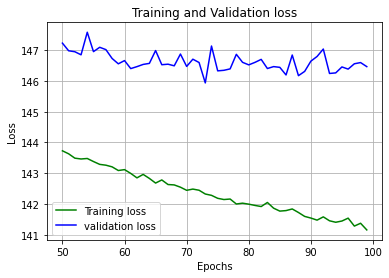

In [26]:
offset = epochs//2
loss_train = hist_conv.history['loss']
loss_val = hist_conv.history['val_loss']
epochs_x = range(offset, epochs)
plt.plot(epochs_x, loss_train[offset:], 'g', label='Training loss')
plt.plot(epochs_x, loss_val[offset:], 'b', label='validation loss')
plt.grid()
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
del hist_conv

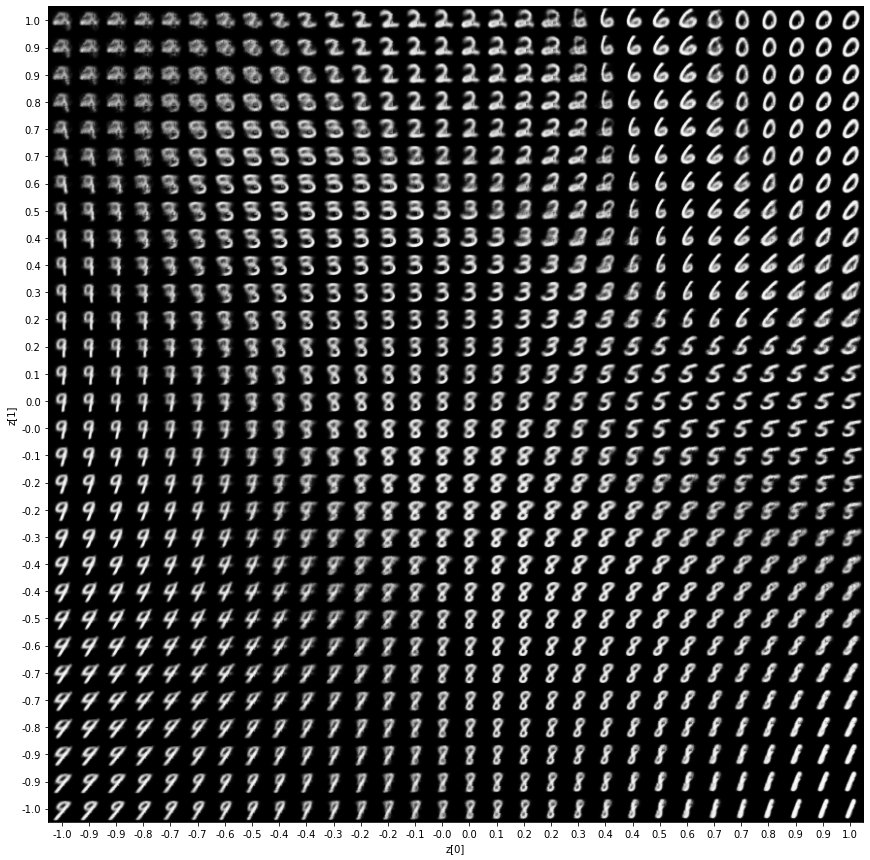

In [35]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder(z_sample)
            x_decoded = x_decoded.numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae_conv)

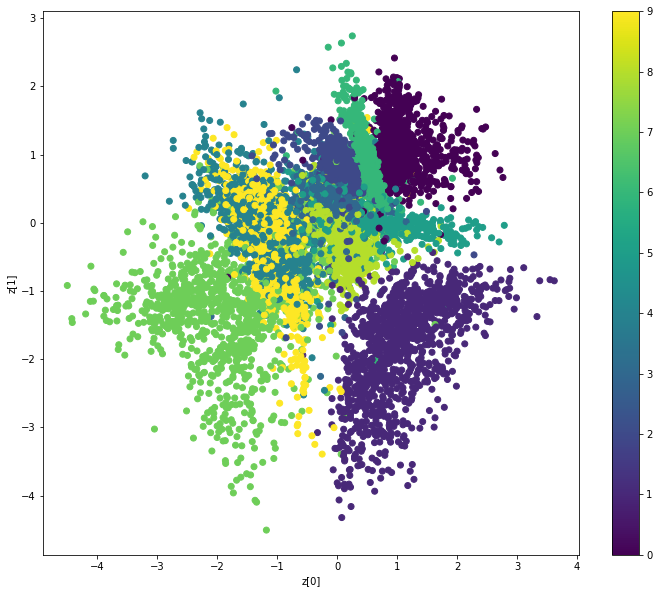

In [38]:
def plot_label_clusters(vae_conv, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae_conv.encoder(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

# plot_label_clusters(vae_conv, x_train, y_train)
plot_label_clusters(vae_conv, x_test, y_test)

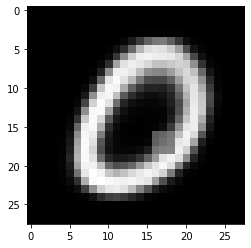

In [39]:
digit_size = 28

z_sample = np.array([[1, 1]])
x_decoded = vae_conv.decoder(z_sample)
x_decoded = x_decoded.numpy()
digit = x_decoded[0].reshape(digit_size, digit_size)
plt.imshow(digit, cmap='gray')
